In [55]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
import pandas as pd
import time
from langdetect import detect
import nltk
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

We used Selenium and Chrome WebDriver to scrape and extract English-language comments from a YouTube video's comments section.

In [4]:
def ScrapComment(url):
    driver = webdriver.Chrome()

    # Open the YouTube video URL
    driver.get(url)


    # Scroll down to load comments (you can adjust this based on the number of comments you want)
    for _ in range(70):  # Scroll down 70 times
        driver.find_element(By.TAG_NAME, 'body').send_keys(Keys.END)
        time.sleep(2)  

    # Find and extract the comment elements
    comment_elements = driver.find_elements(By.CSS_SELECTOR, '#content #content-text')
    
    # Print the comments
    for comment in comment_elements:
        text = comment.text
        try:
            # Attempt to detect the language of the comment
            language = detect(text)
            if language == 'en':
                comments_dict['Comments'].append(text)
        except Exception as e:
            print(f"Error processing comment: {str(e)}")



    #Close the WebDriver
    driver.quit()


In [5]:
# url = 'https://www.youtube.com/watch?v=BSYsXVFzmKA&ab_channel=Samsung'
# ScrapComment(url)

In [6]:
# print(comments_dict)

In [7]:
# Convert the dictionary into a DataFrame
comments_df = pd.read_csv('youtube_comments.csv')
comments_df.head(10)

,Comments
0,Play on with a super powerful processor and s...
1,Ok this is awesome. Im so happy that Samsung i...
2,By far the most creative and captivating intro...
3,"Ever since the S22 Ultra, I've been the bigges..."
4,The introduction film is impecceable! Looooove...
5,One of my favorite features has to be the OIS....
6,Nostalgia to the times when smartphone introdu...
7,This is actually such an elaborate and fun int...
8,I always wait for new Samsung introduction vid...
9,Never seen Samsung pull out an epic commercial...


In [8]:
comments_df.shape

(1014, 1)

In [9]:
comments_df['Comment_ID'] = range(1, len(comments_df) + 1)

In [10]:
comments_df.head()

,Comments,Comment_ID
0,Play on with a super powerful processor and s...,1
1,Ok this is awesome. Im so happy that Samsung i...,2
2,By far the most creative and captivating intro...,3
3,"Ever since the S22 Ultra, I've been the bigges...",4
4,The introduction film is impecceable! Looooove...,5


Explaination on how me assigned positive, negative and neutural scores for the comments

For this we have used Natural Language Toolkit

The Natural Language Toolkit (NLTK) is a platform used for building Python programs that work with human language data for applying in statistical natural language processing (NLP). It contains text processing libraries for tokenization, parsing, classification, stemming, tagging and semantic reasoning.

In [11]:
example = comments_df['Comments'][5]
print(example)

One of my favorite features has to be the OIS. The videos taken out of this phone are so so stable, missing all those micro jitters from when usually filming with a phone, it's incredible and makes other phones with OIS feel like they ain't got one.


Tokenization is the process of dividing a text (in this case, stored in the variable example) into individual words or tokens, and tokens[:10] retrieves the first 10 tokens from the tokenized text.

In [12]:
tokens = nltk.word_tokenize(example)
tokens[:10]

['One', 'of', 'my', 'favorite', 'features', 'has', 'to', 'be', 'the', 'OIS']

The code uses NLTK's pos_tag to tag the parts of speech for each token in the tokens list, and tagged[:10] extracts the parts of speech tags for the first 10 tokens.

In [13]:
tagged = nltk.pos_tag(tokens)
tagged[:10]

[('One', 'CD'),
 ('of', 'IN'),
 ('my', 'PRP$'),
 ('favorite', 'JJ'),
 ('features', 'NNS'),
 ('has', 'VBZ'),
 ('to', 'TO'),
 ('be', 'VB'),
 ('the', 'DT'),
 ('OIS', 'NNP')]

'CD': Cardinal Number
'IN': Preposition or Subordinating Conjunction
'PRP$': Possessive Pronoun
'JJ': Adjective
'NNS': Noun, Plural
'VBZ': Verb, 3rd Person Singular Present
'TO': to
'VB': Verb, Base Form
'DT': Determiner
'NNP': Proper Noun, Singular

In [14]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

`SentimentIntensityAnalyzer` is a class from the VADER (Valence Aware Dictionary and sEntiment Reasoner) sentiment analysis tool. It's used to perform sentiment analysis on text by assigning sentiment scores (positive, negative, or neutral) to words and phrases in the text, ultimately providing a compound sentiment score for the entire text.

In [15]:
# Create a SentimentIntensityAnalyzer object
sia = SentimentIntensityAnalyzer()

In [16]:
sia.polarity_scores(example)

{'neg': 0.051, 'neu': 0.786, 'pos': 0.163, 'compound': 0.716}

This code processes comments from a DataFrame, calculates sentiment scores for each comment using the `SentimentIntensityAnalyzer`, and stores the results in a dictionary, where comment IDs are used as keys.

In [17]:
res = {}
for i, row in tqdm(comments_df.iterrows(), total=len(comments_df)):
    text = row['Comments']
    myid = row['Comment_ID']
    res[myid] = sia.polarity_scores(text)

  0%|          | 0/1014 [00:00<?, ?it/s]

In [18]:
vaders = pd.DataFrame(res).T
vaders

,neg,neu,pos,compound
1,0.000,0.601,0.399,0.8834
2,0.018,0.624,0.358,0.9735
3,0.000,0.811,0.189,0.5400
4,0.000,0.741,0.259,0.9059
5,0.000,1.000,0.000,0.0000
...,...,...,...,...
1010,0.536,0.464,0.000,-0.8439
1011,0.000,1.000,0.000,0.0000
1012,0.000,0.506,0.494,0.5994
1013,0.000,1.000,0.000,0.0000


Compound Score = (Sum of Sentiment Scores of Words in the Text) / (Number of Words in the Text)

In [19]:
vaders['Comment_ID'] = range(1, len(comments_df) + 1)

In [20]:
vaders = vaders .reset_index().rename(columns={'index':'id'})

vaders = vaders.merge(comments_df, how='left')

In [21]:
vaders.head(10)

,id,neg,neu,pos,compound,Comment_ID,Comments
0,1,0.000,0.601,0.399,0.8834,1,Play on with a super powerful processor and s...
1,2,0.018,0.624,0.358,0.9735,2,Ok this is awesome. Im so happy that Samsung i...
2,3,0.000,0.811,0.189,0.5400,3,By far the most creative and captivating intro...
3,4,0.000,0.741,0.259,0.9059,4,"Ever since the S22 Ultra, I've been the bigges..."
4,5,0.000,1.000,0.000,0.0000,5,The introduction film is impecceable! Looooove...
5,6,0.051,0.786,0.163,0.7160,6,One of my favorite features has to be the OIS....
6,7,0.000,0.539,0.461,0.8779,7,Nostalgia to the times when smartphone introdu...
7,8,0.000,0.715,0.285,0.7500,8,This is actually such an elaborate and fun int...
8,9,0.000,0.667,0.333,0.8176,9,I always wait for new Samsung introduction vid...
9,10,0.000,0.775,0.225,0.4404,10,Never seen Samsung pull out an epic commercial...


This code defines sentiment thresholds and categorizes sentiment based on compound scores, creating a new 'Sentiment Category' column for analysis, and saves the results to a CSV file.

In [22]:
# Define threshold values for sentiment categories
threshold_positive = 0.15
threshold_negative = -0.15

# Create a function to categorize sentiment based on compound score
def categorize_sentiment(compound):
    if compound >= threshold_positive:
        return 1
    elif compound <= threshold_negative:
        return -1
    else:
        return 0

# Apply the categorization function to create a 'Sentiment Category' column
vaders['Sentiment Category'] = vaders['compound'].apply(categorize_sentiment)

# Now you can use 'Sentiment Category' for your analysis and plotting

vaders.to_csv('youtube_comments_sentiment.csv', index=False)


In [23]:
vaders.head(10)

,id,neg,neu,pos,compound,Comment_ID,Comments,Sentiment Category
0,1,0.000,0.601,0.399,0.8834,1,Play on with a super powerful processor and s...,1
1,2,0.018,0.624,0.358,0.9735,2,Ok this is awesome. Im so happy that Samsung i...,1
2,3,0.000,0.811,0.189,0.5400,3,By far the most creative and captivating intro...,1
3,4,0.000,0.741,0.259,0.9059,4,"Ever since the S22 Ultra, I've been the bigges...",1
4,5,0.000,1.000,0.000,0.0000,5,The introduction film is impecceable! Looooove...,0
5,6,0.051,0.786,0.163,0.7160,6,One of my favorite features has to be the OIS....,1
6,7,0.000,0.539,0.461,0.8779,7,Nostalgia to the times when smartphone introdu...,1
7,8,0.000,0.715,0.285,0.7500,8,This is actually such an elaborate and fun int...,1
8,9,0.000,0.667,0.333,0.8176,9,I always wait for new Samsung introduction vid...,1
9,10,0.000,0.775,0.225,0.4404,10,Never seen Samsung pull out an epic commercial...,1


# EDA


In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np

### Histogram

This provides a clear visualization of the distributions of different sentiment scores (negative, neutral, positive, and compound), allowing for a quick assessment of the sentiment characteristics within the dataset.

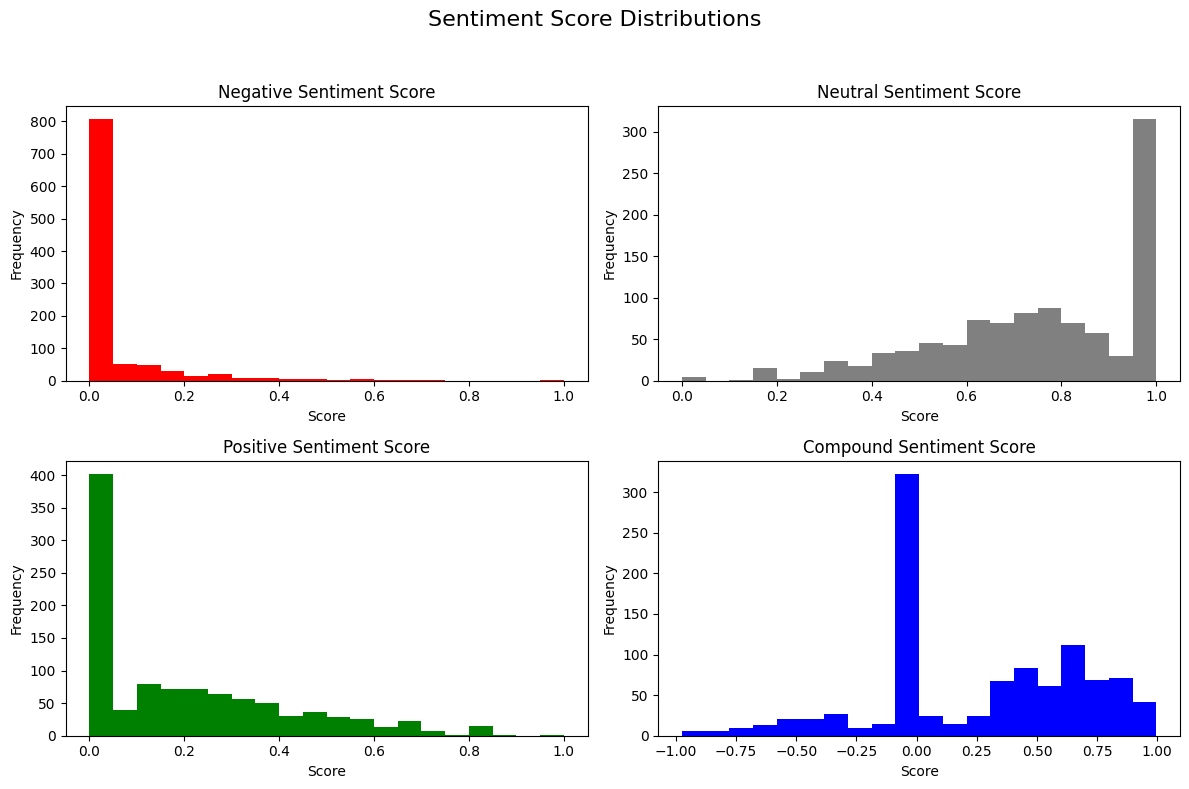

In [25]:
# Create subplots for each sentiment score
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle('Sentiment Score Distributions', fontsize=16)

# Negative Sentiment Score
axes[0, 0].hist(vaders['neg'], bins=20, color='red')
axes[0, 0].set_title('Negative Sentiment Score')
axes[0, 0].set_xlabel('Score')
axes[0, 0].set_ylabel('Frequency')

# Neutral Sentiment Score
axes[0, 1].hist(vaders['neu'], bins=20, color='gray')
axes[0, 1].set_title('Neutral Sentiment Score')
axes[0, 1].set_xlabel('Score')
axes[0, 1].set_ylabel('Frequency')

# Positive Sentiment Score
axes[1, 0].hist(vaders['pos'], bins=20, color='green')
axes[1, 0].set_title('Positive Sentiment Score')
axes[1, 0].set_xlabel('Score')
axes[1, 0].set_ylabel('Frequency')

# Compound Sentiment Score
axes[1, 1].hist(vaders['compound'], bins=20, color='blue')
axes[1, 1].set_title('Compound Sentiment Score')
axes[1, 1].set_xlabel('Score')
axes[1, 1].set_ylabel('Frequency')

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Show the plots
plt.show()

### Boxplot

It provides a visual representation of the spread and distribution of sentiment scores. Outliers in the data can be readily spotted as individual data points beyond the whiskers, making it a valuable tool for outlier detection and understanding the data's variability.

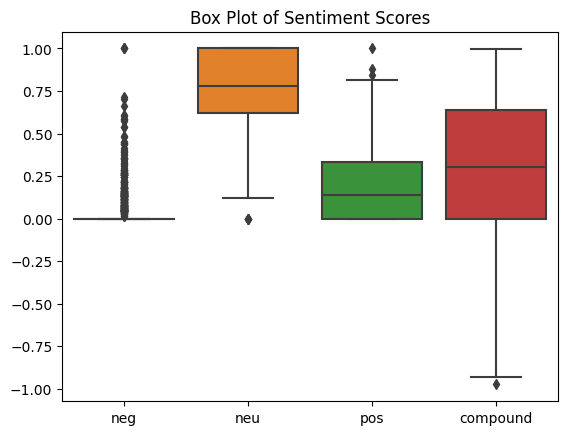

In [45]:
sns.boxplot(data=vaders[['neg', 'neu', 'pos', 'compound']])
plt.title('Box Plot of Sentiment Scores')
plt.show()

# import seaborn as sns
# import matplotlib.pyplot as plt

# # Calculate the mean of 'neg' sentiment scores
# neg_mean = vaders['neg'].mean()

# # Create a box plot with the mean
# plt.figure(figsize=(8, 6))
# sns.boxplot(data=vaders[['neg', 'neu', 'pos', 'compound']])
# plt.title(f'Box Plot of Sentiment Scores (Mean neg: {neg_mean:.2f})')
# plt.show()


# import numpy as np

# # Add a small constant (e.g., 0.01) to ensure all values are positive
# vaders['log_neg'] = np.log(vaders['neg'] + 0.01)

# sns.boxplot(data=vaders[['log_neg', 'neu', 'pos', 'compound']])
# plt.title('Box Plot of Scaled Sentiment Scores')
# plt.show()

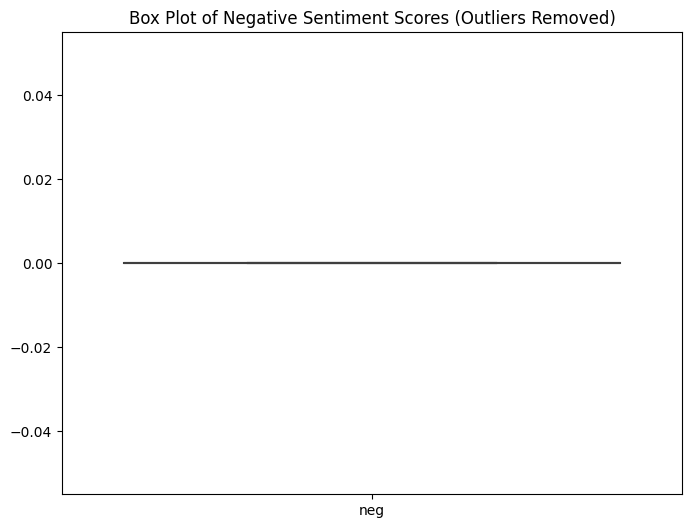

In [47]:
# Filter out outliers in the 'neg' column
Q1 = vaders['neg'].quantile(0.25)
Q3 = vaders['neg'].quantile(0.75)
IQR = Q3 - Q1
neg_no_outliers = vaders[(vaders['neg'] >= Q1 - 1.5 * IQR) & (vaders['neg'] <= Q3 + 1.5 * IQR)]

# Create a box plot for the filtered data
plt.figure(figsize=(8, 6))
sns.boxplot(data=neg_no_outliers[['neg']])
plt.title('Box Plot of Negative Sentiment Scores (Outliers Removed)')
plt.show()

    In the column of negative comments of dataframe each value is unique and Because of that it is considering every value as unique value and considering as outlier we can see the same in the negative comments without outlier in the above boxplot graph.

### Bar Plot

This bar graph visually represents the distribution of sentiment categories (positive, neutral, and negative) in the dataset, showing the count of comments in each category.

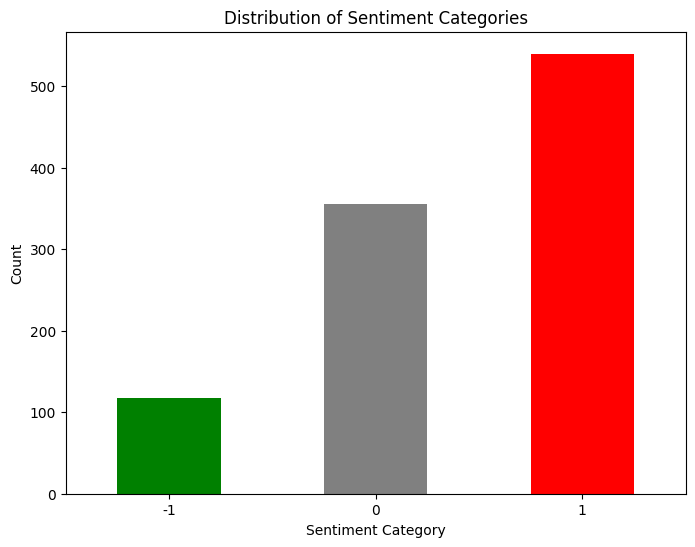

In [27]:
# Group the data by sentiment categories (positive, neutral, negative)
sentiment_counts = vaders.groupby(['Sentiment Category']).size()

# Create a bar plot
plt.figure(figsize=(8, 6))
sentiment_counts.plot(kind='bar', color=['green', 'gray', 'red'])
plt.title('Distribution of Sentiment Categories')
plt.xlabel('Sentiment Category')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

### Pie Chart

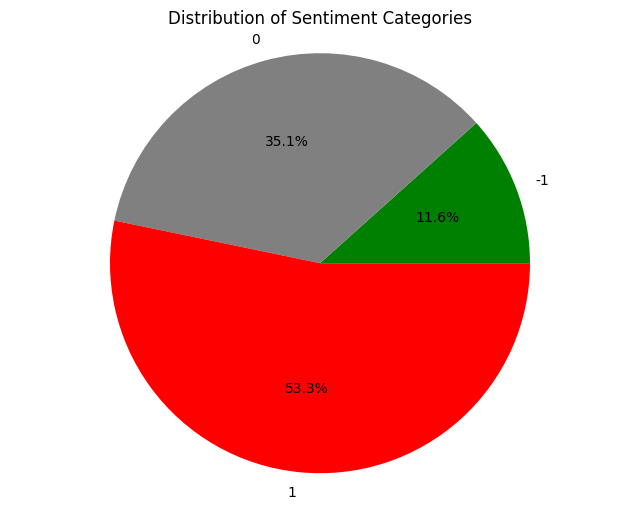

In [28]:
plt.figure(figsize=(8, 6))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', colors=['green', 'gray', 'red'])
plt.title('Distribution of Sentiment Categories')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

### Scatterplot

The importance of this graph is to visually explore the relationship between the compound sentiment score and positive sentiment score while distinguishing sentiment categories, facilitating the understanding of how these scores vary across different categories.

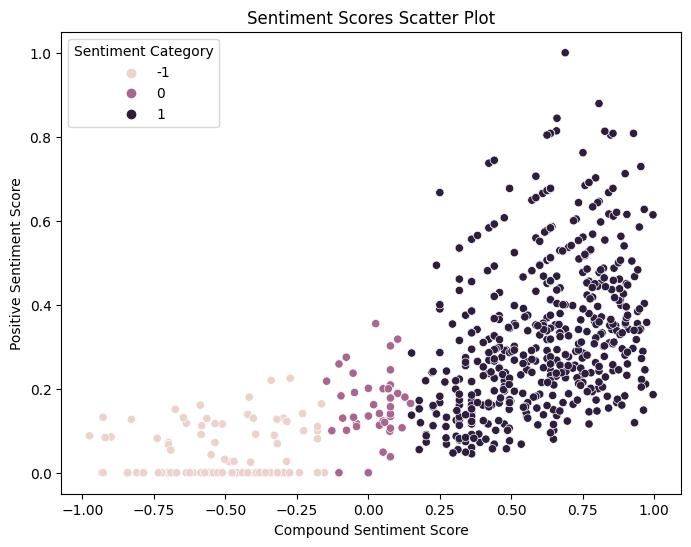

In [29]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='compound', y='pos', hue='Sentiment Category', data=vaders)
plt.title('Sentiment Scores Scatter Plot')
plt.xlabel('Compound Sentiment Score')
plt.ylabel('Positive Sentiment Score')
plt.show()

### Pairplot

This graph is important for understanding the relationships between different sentiment scores (positive, neutral, negative, and compound) by visually displaying how they interact.

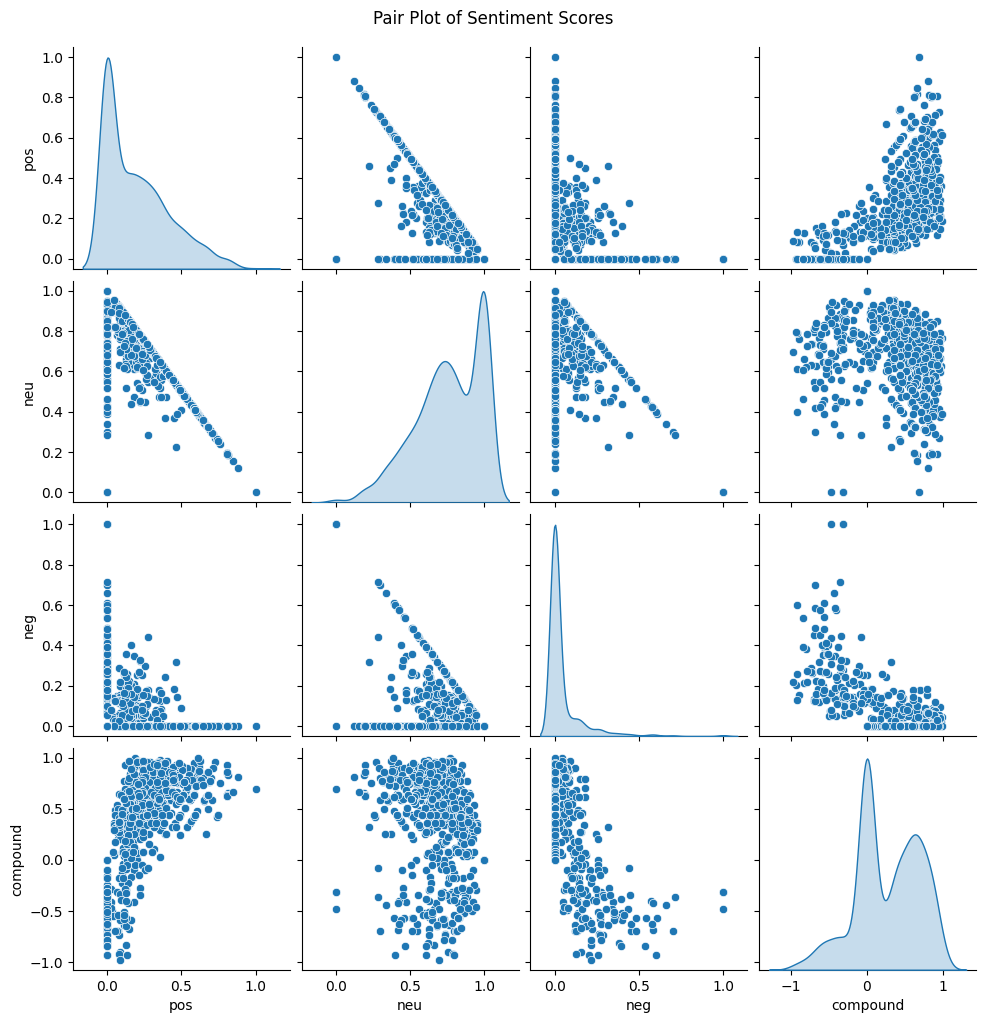

In [30]:
sns.pairplot(vaders[['pos', 'neu', 'neg', 'compound']], diag_kind='kde', markers=['o', 's', 'D'])
plt.suptitle('Pair Plot of Sentiment Scores', y=1.02)
plt.show()


### Heatmap

This graph is essential for understanding how different sentiment scores (positive, neutral, negative, and compound) are related, helping to identify patterns and dependencies among them.

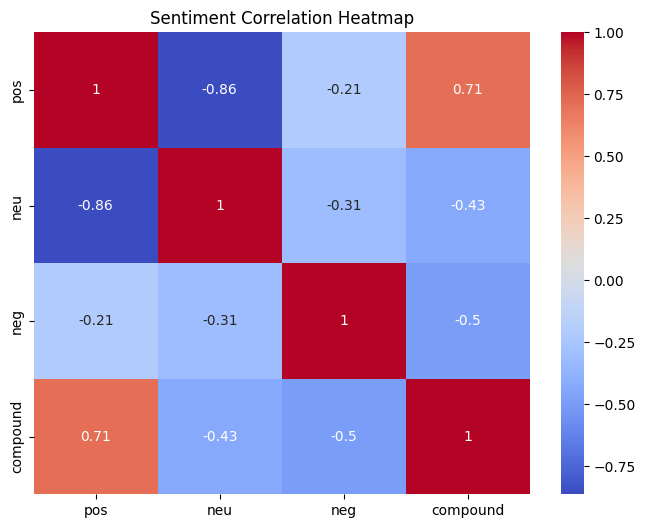

In [31]:
correlation_matrix = vaders[['pos', 'neu', 'neg', 'compound']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Sentiment Correlation Heatmap')
plt.show()


# Modeling

In [32]:
x = vaders['Comments']
y = vaders['Sentiment Category']

x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.30,random_state=64)

In [33]:
tfidf = TfidfVectorizer()
x_train_vect = tfidf.fit_transform(x_train)
x_test_vect = tfidf.transform(x_test)

In [34]:
knn = KNeighborsClassifier(n_neighbors=15)
knn.fit(x_train_vect,y_train)

KNeighborsClassifier(n_neighbors=15)

1) Accuracy
2) Precision
3) Recall
4) F1-score
11) Confusion Matrix

In [35]:
knn_pred = knn.predict(x_test_vect)
print('Confusion Matrix :\n',confusion_matrix(y_test,knn_pred))
print(classification_report(y_test,knn_pred))
accuracy = accuracy_score(y_test,knn_pred)
print('Accuracy:',accuracy)

Confusion Matrix :
 [[  2   5  21]
 [  0  60  54]
 [  0  16 147]]
              precision    recall  f1-score   support

          -1       1.00      0.07      0.13        28
           0       0.74      0.53      0.62       114
           1       0.66      0.90      0.76       163

    accuracy                           0.69       305
   macro avg       0.80      0.50      0.50       305
weighted avg       0.72      0.69      0.65       305

Accuracy: 0.6852459016393443


In [36]:
# confusion_matrix=np.array([[  2 ,  5 , 21],
#  [  0 , 60 , 54],
#  [  0 , 16 ,147]])
# print(confusion_matrix)

[[  2   5  21]
 [  0  60  54]
 [  0  16 147]]


In [37]:
confusion = confusion_matrix
# Assuming y_true are the true labels and y_pred are the predicted labels
num_classes = confusion.shape[0]
TPR = []
FPR = []
Jaccard_Indices = []
for i in range(num_classes):
    TP = confusion[i, i]  # True Positives for class i
    FN = sum(confusion[i, :]) - TP  # False Negatives for class i
    FP = sum(confusion[:, i]) - TP  # False Positives for class i
    TN = sum(sum(confusion)) - TP - FN - FP  # True Negatives for class i

    tpr = TP / (TP + FN)  # True Positive Rate for class i
    fpr = FP / (FP + TN)  # False Positive Rate for class i
    jaccard_index = TP / (TP + FN + FP)  # Jaccard Index for class i
    Jaccard_Indices.append(jaccard_index)
    TPR.append(tpr)
    FPR.append(fpr)

for i in range(num_classes):
    print(f"Class {i} - True Positive Rate (TPR): {TPR[i]:.2f}, False Positive Rate (FPR): {FPR[i]:.2f}")
    print(f"Class {i} - Jaccard Index: {Jaccard_Indices[i]:.2f}")

Class 0 - True Positive Rate (TPR): 0.07, False Positive Rate (FPR): 0.00
Class 0 - Jaccard Index: 0.07
Class 1 - True Positive Rate (TPR): 0.53, False Positive Rate (FPR): 0.11
Class 1 - Jaccard Index: 0.44
Class 2 - True Positive Rate (TPR): 0.90, False Positive Rate (FPR): 0.53
Class 2 - Jaccard Index: 0.62


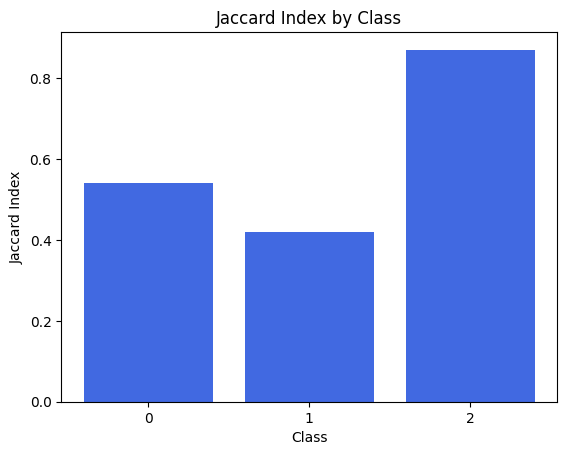

In [38]:
import matplotlib.pyplot as plt

# Define the Jaccard Indices for each class
class_data = [
    {"Class": 0, "Jaccard Index": 0.54},
    {"Class": 1, "Jaccard Index": 0.42},
    {"Class": 2, "Jaccard Index": 0.87},
]

# Extract class labels and Jaccard Indices
class_labels = [item["Class"] for item in class_data]
jaccard_indices = [item["Jaccard Index"] for item in class_data]

# Create a bar chart to visualize Jaccard Indices for each class
plt.bar(class_labels, jaccard_indices, color='royalblue')
plt.xlabel('Class')
plt.ylabel('Jaccard Index')
plt.title('Jaccard Index by Class')
plt.xticks(class_labels)
plt.show()

In [78]:
from sklearn.ensemble import RandomForestClassifier

# Create a Random Forest classifier
random_forest_model = RandomForestClassifier(n_estimators=68, random_state=58)

# Train the model on the training data
random_forest_model.fit(x_train_vect, y_train)

# Make predictions on the test data
y_pred_rf = random_forest_model.predict(x_test_vect)

# Evaluate the Random Forest model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
confusion_mat_rf = confusion_matrix(y_test, y_pred_rf)
classification_rep_rf = classification_report(y_test, y_pred_rf)

# Print the evaluation metrics for the Random Forest model
print("Random Forest Accuracy:", accuracy_rf)
print("Random Forest Confusion Matrix:\n", confusion_mat_rf)
print("Random Forest Classification Report:\n", classification_rep_rf)


Random Forest Accuracy: 0.7180327868852459
Random Forest Confusion Matrix:
 [[  2   9  17]
 [  1  79  34]
 [  0  25 138]]
Random Forest Classification Report:
               precision    recall  f1-score   support

          -1       0.67      0.07      0.13        28
           0       0.70      0.69      0.70       114
           1       0.73      0.85      0.78       163

    accuracy                           0.72       305
   macro avg       0.70      0.54      0.54       305
weighted avg       0.71      0.72      0.69       305



We have first applied KNN model on the sentiment analyis but the accuracy was not good enough and it was unable to classify the comments into Positive Negative Neutral so we have applied the Random Forest Classfier to increase the accuracy of the model and to get better prediction.